# Predicting House prices

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load data

In [2]:
house_data = pd.read_csv(
    '/opt/conda/lib/python3.9/site-packages/sklearn/datasets/data/boston_house_prices.csv',
    header=1
)
house_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
base_features = house_data.columns.tolist()
base_features = base_features[:len(base_features)-1]
base_features

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

**CRIM** per capita crime rate by town

**ZN** proportion of residential land zoned for lots over 25,000 sq.ft.

**INDUS** proportion of non-retail business acres per town

**CHAS** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

**NOX** nitric oxides concentration (parts per 10 million)

**RM** average number of rooms per dwelling

**AGE** proportion of owner-occupied units built prior to 1940

**DIS** weighted distances to five Boston employment centres

**RAD** index of accessibility to radial highways

**TAX** full-value property-tax rate per $10,000

**PTRATIO** pupil-teacher ratio by town

**B** 1000(Bk - 0.63)^2 where Bk is the proportion of black people by town

**LSTAT** % lower status of the population

**MEDV** Median value of owner-occupied homes in $1000’s

In [4]:
for col in house_data.columns:
    print(col)
    print(f'Value type: {house_data[col].dtype}')
    print(f'number of unique values: {house_data[col].nunique()}')
    print(f'top five unique values: {house_data[col].unique()[:5]}')
    print()

CRIM
Value type: float64
number of unique values: 504
top five unique values: [0.00632 0.02731 0.02729 0.03237 0.06905]

ZN
Value type: float64
number of unique values: 26
top five unique values: [18.   0.  12.5 75.  21. ]

INDUS
Value type: float64
number of unique values: 76
top five unique values: [2.31 7.07 2.18 7.87 8.14]

CHAS
Value type: int64
number of unique values: 2
top five unique values: [0 1]

NOX
Value type: float64
number of unique values: 81
top five unique values: [0.538 0.469 0.458 0.524 0.499]

RM
Value type: float64
number of unique values: 446
top five unique values: [6.575 6.421 7.185 6.998 7.147]

AGE
Value type: float64
number of unique values: 356
top five unique values: [65.2 78.9 61.1 45.8 54.2]

DIS
Value type: float64
number of unique values: 412
top five unique values: [4.09   4.9671 6.0622 5.5605 5.9505]

RAD
Value type: int64
number of unique values: 9
top five unique values: [1 2 3 5 4]

TAX
Value type: int64
number of unique values: 66
top five unique

In [5]:
house_data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

🔍 there are no none values

<AxesSubplot:xlabel='MEDV', ylabel='Count'>

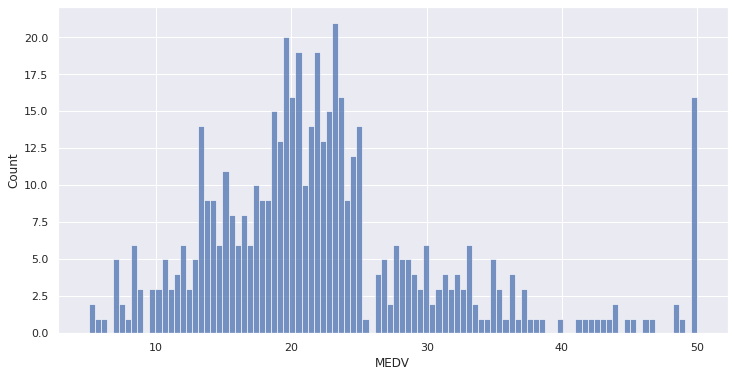

In [6]:
sns.set(rc={'figure.figsize':(12,6)})

sns.histplot(house_data.MEDV, bins=100)

🔍 there appear to be some outliers at the upper end of the price range, we may choose to ignore these so we can get more accurate predictions.

In [7]:
house_data = house_data[house_data['MEDV'] < 48]

In [8]:
medv_logs = np.log1p(house_data.MEDV)

<AxesSubplot:xlabel='MEDV', ylabel='Count'>

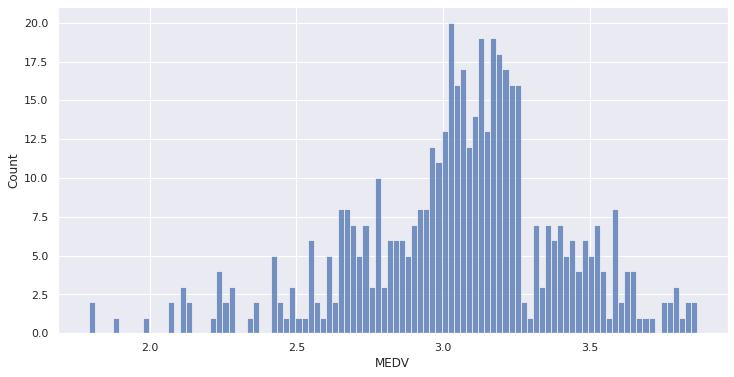

In [9]:
sns.histplot(medv_logs, bins=100)

In [10]:
round(house_data['MEDV'].mean(), 2)

21.47

In [11]:
round(house_data['MEDV'].median(),2)

20.8

## Data preparation & pipeline

In [12]:
# split data into test, train and validate sub sets
n = len(house_data)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [13]:
np.random.seed(42)

idx = np.arange(n)
np.random.shuffle(idx)

In [14]:
def split_data(id, df):
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train.MEDV.values)
    y_val = np.log1p(df_val.MEDV.values)
    y_test = np.log1p(df_test.MEDV.values)
    
    return df_train, df_val, df_test, y_train, y_val, y_test


def prepare_X(df):
    df = df.copy()
    features = base_features.copy()

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X


def train_linear_regression_regularised(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


def rmse(y, y_pred):
    err = y - y_pred
    se = err ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Tuning the model

In [15]:
scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(idx, house_data)
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_regularised(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    scores.append(score)
    
    print(f' seed: {seed}, bias term: {round(w0, 2)}, score: {round(score, 2)}')

 seed: 0, bias term: 4.2, score: 0.16
 seed: 1, bias term: 4.28, score: 0.16
 seed: 2, bias term: 3.66, score: 0.19
 seed: 3, bias term: 3.97, score: 0.19
 seed: 4, bias term: 3.84, score: 0.17
 seed: 5, bias term: 4.16, score: 0.15
 seed: 6, bias term: 4.22, score: 0.16
 seed: 7, bias term: 4.08, score: 0.17
 seed: 8, bias term: 3.53, score: 0.16
 seed: 9, bias term: 4.08, score: 0.18


🔍 the best seed value would be `8`

In [16]:
np.random.seed(8)

idx = np.arange(n)
np.random.shuffle(idx)

df_train, df_val, df_test, y_train, y_val, y_test = split_data(idx, house_data)

for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_regularised(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(f' regularisation: {r}, bias term: {round(w0,2)}, score: {round(score,2)}')

 regularisation: 0.0, bias term: 3.53, score: 0.16
 regularisation: 1e-05, bias term: 3.53, score: 0.16
 regularisation: 0.0001, bias term: 3.53, score: 0.16
 regularisation: 0.001, bias term: 3.53, score: 0.16
 regularisation: 0.1, bias term: 2.93, score: 0.17
 regularisation: 1, bias term: 1.24, score: 0.2
 regularisation: 10, bias term: 0.23, score: 0.24


🔍 the best regularisation value here would be `0.001`

## Using the model

In [17]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(idx, house_data)

full_train = pd.concat([df_train, df_val])
full_train = full_train.reset_index(drop=True) # we reset the index here as we still have the index from the validation data
full_y = np.concatenate([y_train, y_val])

In [18]:
r = 0.1
X_train = prepare_X(full_train)
w0, w = train_linear_regression_regularised(X_train, full_y, r=r)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
round(score,2)

0.2

In [19]:
house = df_test.iloc[10].to_dict() # we take one value from our test data, in real life this would have been entered by a user
df_small = pd.DataFrame([house])
df_small

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.7258,0.0,8.14,0.0,0.538,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28,18.2


In [20]:
X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

2.994656513531126

In [21]:
round(np.expm1(y_pred),2)

18.98

In [22]:
round(np.expm1(y_test[10]),2)

18.2

🔍 our model slightly over predicts but is pretty close!